In [1]:
from nltk.util import ngrams
from nltk.corpus import stopwords
import nltk
import pandas as pd
import csv
import re
import string
import pickle
import numpy as np

In [2]:
%matplotlib inline
nltk.download(info_or_id='stopwords')
nltk.download(info_or_id='punkt')
sw = set(stopwords.words("english")) | set(i.strip() for i in list(open('stopwordlist.txt'))[1:])
terms_df = pd.read_csv('finalterms_grouped_clean2.csv')
single_terms = set(b for a in terms_df['term'] for b in nltk.word_tokenize(a) if (b not in sw and len(b)> 1))
del stopwords
del terms_df
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
puncs = set(string.punctuation)

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def return_words_from_text(x):
    return tuple(tuple(nltk.word_tokenize(re.sub(r'\d+','SOMENUM',sent.lower()))) for sent in sent_detector.tokenize(x.strip()))

def get_ngrams(x, ngram_start, ngram_end):
    def remove_punc(ngram):
        return tuple(gram for gram in ngram if not all(j in puncs for j in gram))
    def check_num_only(ngram):
        return set(ngram) != set('SOMENUM')
          
    ngram_list = []
    for sent in x:
        for i in range(ngram_start,ngram_end+1):
            ngram_list += [gram for gram in map(remove_punc, ngrams(sent, i)) if ~check_num_only(gram)]
    return set(ngram_list)

In [4]:
def read_trc2_cleanonly(filepath, max_row=10000000):
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        next(f)
        for idx, line in enumerate(f):
            if idx >= max_row:
                #print(line)
                break
            yield line.replace('\0','')

In [5]:
def read_Articles(trc_reader, function='returnDF', max_rows=100000):
    invalid_sentences_startswith = ('DIARY', '*TOP NEWS*','NYSE ', 'SERVICE ALERT', 'TABLE', 'BSE Block', '---- Reuters',
                               '(Sebi announcement)','ADVISORY', 'AMEX ', 'NASDAQ ', 'LIFFE ', 'LME closing prices')

    reader = csv.reader(trc_reader)
    articles = []

    for idx,i in enumerate(reader):

        if i[2] != '':
            j = {}
            j['title'] = i[1].strip()
            if not j['title'].startswith(invalid_sentences_startswith):
                j['content'] = i[2].strip()
                j['unique_words'] = set(w for w in nltk.word_tokenize(j['content'].lower()) if 
                                        (w not in sw and not all(j in puncs for j in w) ) )
                j['article_word_len'] = len(j['unique_words'])
                if j['article_word_len'] > 20:
                    j['percentage_of_bterm'] = len(set(y for y in j['unique_words'] if y in single_terms))/ \
                                                    len(set(j['unique_words'])) if len(set(j['unique_words'])) > 0 else 0
                    
                    if function=='returnDF':
                        articles.append(j)
                    elif function=='returnStrings':
                        yield re.sub(r'\d+','SOMENUM',j['content'].lower())
                    elif function=='returnRow':
                        yield j
                    
        if idx%1000 ==0:
            print("scanned {idx}".format(idx=idx))
        if idx >= max_rows:
            break
            
    if function=='returnDF':
        return pd.DataFrame(articles)

In [6]:
def save_ngrams(row_input, business_article_threshold, business_term_threshold, outputPath):
    
    function = {'business': lambda gram: sum(1 for g in gram if g in single_terms)/len(gram) >= business_term_threshold if len(gram)>0 else False,
                'nonbusiness': lambda gram: True
               }
    
    with open(outputPath,'w') as writefile:
        str_format = "{TERM}\t{NGRAM}\t{ROWNUM}\t{TERMTYPE}\n"
        writefile.write(str_format.format(TERM='TERM', NGRAM='NGRAM', ROWNUM='ROWNUM', TERMTYPE='TERMTYPE'))
        for idx, r in enumerate(row_input):
            article_type = 'business' if r['percentage_of_bterm'] >= business_article_threshold else 'nonbusiness'
            for gram in get_ngrams(return_words_from_text(r['content']), 1, 10):
                if function[article_type](gram):
                    writefile.write(str_format.format(TERM=' '.join(gram), NGRAM=len(gram), ROWNUM=idx, TERMTYPE=article_type, ))
            if idx%1000 ==0:
                print("valid articles count {idx}".format(idx=idx))

In [9]:
str([0.3,0.4,0.5,0.6,0.7,0.8,0.9][0]).replace('.','')

'03'

In [7]:
for i in [0.3,0.4,0.6,0.7,0.8,0.9]:
    print("running with threshold... {}".format(i))
    save_ngrams(read_Articles(read_trc2_cleanonly(r'trc2.csv'), function='returnRow', max_rows=10000), 0.2, i, 'ngrams_from10k_{}_threshold.csv'.format(str(i).replace('.','')))

running with threshold... 0.3
valid articles count 0
scanned 0
scanned 1000
valid articles count 1000
scanned 2000
valid articles count 2000
scanned 3000
scanned 4000
valid articles count 3000
scanned 5000
scanned 6000
valid articles count 4000
scanned 7000
valid articles count 5000
scanned 8000
scanned 9000
scanned 10000
running with threshold... 0.4
valid articles count 0
scanned 0
scanned 1000
valid articles count 1000
scanned 2000
valid articles count 2000
scanned 3000
scanned 4000
valid articles count 3000
scanned 5000
scanned 6000
valid articles count 4000
scanned 7000
valid articles count 5000
scanned 8000
scanned 9000
scanned 10000
running with threshold... 0.6
valid articles count 0
scanned 0
scanned 1000
valid articles count 1000
scanned 2000
valid articles count 2000
scanned 3000
scanned 4000
valid articles count 3000
scanned 5000
scanned 6000
valid articles count 4000
scanned 7000
valid articles count 5000
scanned 8000
scanned 9000
scanned 10000
running with threshold... 0.

In [2]:
ngrams_df = pd.read_csv('ngrams_from10k.csv',sep='\t')

In [3]:
ngrams_df

,TERM,NGRAM,ROWNUM,TERMTYPE
0,total c incr SOMENUM.SOMENUM pct jan.SOMENUM at,7,0,nonbusiness
1,hbos treasury frn jul.SOMENUM at par,6,0,nonbusiness
2,dec.SOMENUM SOMENUM.SOMENUM canada housing,4,0,nonbusiness
3,SOMENUM nrw.bank SOMENUM.SOMENUM,3,0,nonbusiness
4,SOMENUM.SOMENUM reoffer mar.SOMENUM SOMENUM.SO...,4,0,nonbusiness
5,at par jun.SOMENUM,3,0,nonbusiness
6,may.SOMENUM SOMENUM cdc SOMENUM.SOMENUM,4,0,nonbusiness
7,dec.SOMENUM at SOMENUM.SOMENUM oct.SOMENUM SOM...,6,0,nonbusiness
8,znvh feb.SOMENUM SOMENUM kfw SOMENUM.SOMENUM pct,6,0,nonbusiness
9,the z-code in brackets to access data for an,9,0,nonbusiness


# TF_IDF vectors

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words=None)
tfs = tfidf.fit_transform(read_Articles(read_trc2_cleanonly(r'trc2.csv'), function='returnStrings', max_rows=10000))
tfs_nonzero = tfs.nonzero()
feature_names = tfidf.get_feature_names()

scanned 0
scanned 1000
scanned 2000
scanned 3000
scanned 4000
scanned 5000
scanned 6000
scanned 7000
scanned 8000
scanned 9000
scanned 10000


In [10]:
feature_dict = {i:idx for idx,i in enumerate(feature_names)}

In [11]:
unique_ngrams2 = ngrams_df[ngrams_df['NGRAM']>1]

In [12]:
current_rownum = 0
def get_vector(col):
    vector = [tfs[col['ROWNUM'],feature_dict[unigram]] if unigram in feature_dict else 0 for unigram in col['TERM'].split(' ')]
    if col['ROWNUM'] > current_rownum:
        print(col['ROWNUM'])
        global current_rownum
        current_rownum +=1000
    return vector + [0]*(10-len(vector))

unique_ngrams2['TERM_VECTOR'] = unique_ngrams2.apply(get_vector, axis=1)
unique_ngrams2['BUSINESS'] = unique_ngrams2['TERMTYPE'].map(lambda x: 1 if x=='business' else 0)
unique_ngrams2.drop(['TERMTYPE'], axis=1, inplace=True)

<ipython-input-12-2d2ce6de18be>:6: SyntaxWarning: name 'current_rownum' is used prior to global declaration
  global current_rownum


1
1001
2001
3001
4001
5001


/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
unique_ngrams2.to_pickle('ngram_10krows_tfidf.pickle')

In [13]:
import sys
sys.getsizeof(unique_ngrams2)

96469826

In [123]:
for i in range(0,10):
    unique_ngrams2['TERM_VECTOR{}'.format(i)] = unique_ngrams2['TERM_VECTOR'].map(lambda x:x[i])
unique_ngrams3 = unique_ngrams2.drop(['TERM_VECTOR'],axis=1)
unique_ngrams3.to_csv(r'D:\unique-ngram_tfidf.csv', sep='\t')

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


# Maximum Likelihood Vectors

In [2]:
def load_unique_ngrams(file):
    ngrams_df = pd.read_csv(file,sep='\t')
    unique_ngram = ngrams_df[ngrams_df['NGRAM']>1].groupby(['TERM','TERMTYPE','NGRAM'])['ROWNUM'].nunique()
    unique_ngram = unique_ngram.reset_index()[['TERM','TERMTYPE','ROWNUM','NGRAM']].rename(columns={'ROWNUM':'OCCURENCES'})
    unique_ngram = unique_ngram[unique_ngram['OCCURENCES']>1]
    unique_ngram['BUSINESS'] = unique_ngram['TERMTYPE'].map(lambda x: 1 if x=='business' else 0)
    unique_ngram.drop(['TERMTYPE'], axis=1, inplace=True)
    return unique_ngram

In [9]:
unique_ngrams2 = load_unique_ngrams('ngrams_from10k.csv')
unique_ngrams2.shape

(784605, 4)

In [4]:
import arpa
def set_vocab(self):
    self.full_vocab = sorted(set(word for ngram in self._ps.keys() for word in ngram))
def vocabulary(self):
    return self.full_vocab
arpa.models.simple.ARPAModelSimple.set_vocab = set_vocab
arpa.models.simple.ARPAModelSimple.vocabulary = vocabulary
models = arpa.loadf("kneyser_ngram.arpa")
lm = models[0]
lm.set_vocab()

(784605, 4)

In [7]:
current_line = 0
def get_vector(term):
    global current_line
    current_line += 1
    if current_line % 1000 ==0:
        print(current_line)
    def get_probability(word):
        try:
            return lm.p(word)
        except:
            return 0
    tokens = term.lower().split(' ')
    unigram = [tokens[0]]
    bigram = []
    trigram = []
    if len(tokens) > 1:
        bigram = [tokens[0:2]] 
    if len(tokens) > 2:
        trigram = [tokens[i-2:i+1] for i in range(2, len(tokens))]
    allgram = unigram+bigram+trigram
    vector = [get_probability(word) for word in allgram ]
    return vector + [0]*(10-len(vector))

In [8]:
from multiprocessing import Pool
num_partitions = 20 #number of partitions to split dataframe
num_cores = 8 #number of cores on your machine
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df
def vector_parallel(data):
    data['TERM_VECTOR'] = data['TERM'].map(get_vector)
    return data
    
unique_ngrams2 = parallelize_dataframe(unique_ngrams2, vector_parallel)

1000
1000
1000
1000
1000
1000
1000
1000
2000
2000
2000
2000
2000
2000
2000
3000
3000
3000
3000
3000
3000
2000
4000
4000
4000
4000
4000
4000
3000
3000
5000
5000
5000
5000
5000
5000
6000
6000
4000
6000
6000
4000
6000
6000
7000
7000
7000
7000
5000
5000
8000
7000
7000
8000
8000
8000
9000
8000
8000
9000
6000
9000
6000
9000
10000
9000
9000
10000
10000
10000
7000
7000
11000
10000
10000
11000
11000
11000
8000
12000
12000
11000
8000
12000
11000
9000
12000
13000
12000
10000
13000
13000
12000
13000
9000
14000
14000
11000
13000
14000
14000
13000
12000
15000
15000
14000
15000
10000
15000
14000
13000
16000
15000
16000
16000
16000
15000
11000
17000
14000
16000
17000
17000
17000
16000
18000
18000
12000
15000
17000
18000
18000
17000
19000
16000
18000
19000
19000
13000
20000
18000
19000
20000
17000
20000
19000
21000
19000
21000
14000
21000
18000
20000
22000
22000
20000
21000
22000
19000
15000
23000
23000
20000
21000
23000
22000
20000
24000
24000
22000
24000
23000
16000
25000
21000
25000
23000
25000
2400

In [10]:
unique_ngrams2

,TERM,OCCURENCES,NGRAM,BUSINESS,TERM_VECTOR
0,'SOMENUM SOMENUM,2,2,0,"[7.423522001309227e-05, 0.002786358544140904, ..."
1,'SOMENUM SOMENUM people,2,3,0,"[7.423522001309227e-05, 0.002786358544140904, ..."
2,'SOMENUM SOMENUM people died,2,4,0,"[7.423522001309227e-05, 0.002786358544140904, ..."
3,'SOMENUM SOMENUM people died today,2,5,0,"[7.423522001309227e-05, 0.002786358544140904, ..."
4,'SOMENUM SOMENUM people died today in,2,6,0,"[7.423522001309227e-05, 0.002786358544140904, ..."
5,'SOMENUM SOMENUM people died today in suicide,2,7,0,"[7.423522001309227e-05, 0.002786358544140904, ..."
6,'SOMENUM SOMENUM people died today in suicide ...,2,8,0,"[7.423522001309227e-05, 0.002786358544140904, ..."
7,'SOMENUM SOMENUM people died today in suicide ...,2,9,0,"[7.423522001309227e-05, 0.002786358544140904, ..."
8,'SOMENUM SOMENUM.SOMENUM,2,2,0,"[7.423522001309227e-05, 0.014364019961893643, ..."
9,'SOMENUM SOMENUM.SOMENUM SOMENUM.SOMENUM,2,3,0,"[7.423522001309227e-05, 0.014364019961893643, ..."


In [11]:
unique_ngrams2.to_pickle('ngram_10krows_ml_kn.pickle')

In [125]:
for i in range(0,10):
    unique_ngrams2['TERM_VECTOR{}'.format(i)] = unique_ngrams2['TERM_VECTOR'].map(lambda x:x[i])
unique_ngrams2 = unique_ngrams2.drop(['TERM_VECTOR'],axis=1)
unique_ngrams2.to_csv('unique-ngram_ml.csv', sep='\t')

In [ ]:
sentences = pickle.load(open('sentences_from100k_articles.pickle','rb'))
with open('sentences_for_srilm.txt','w') as wfile:
    for s in sentences:
        wfile.write(' '.join(s) + '\n')

# Skipgram Word2vec

In [3]:
import gensim
from gensim.models import Word2Vec
from bs4 import BeautifulSoup
import re
import numpy as np

In [37]:
def article_to_sentences( article ):
    raw_sentences = sent_detector.tokenize(article.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append( tuple(nltk.word_tokenize(re.sub(r'\d+','SOMENUM', raw_sentence.lower()))))
    return sentences
sentences = []
for article in read_Articles(read_trc2_cleanonly(r'trc2.csv'), function='returnStrings', max_rows=100000):
    sentences += article_to_sentences(article)

scanned 0
scanned 1000
scanned 2000
scanned 3000
scanned 4000
scanned 5000
scanned 6000
scanned 7000
scanned 8000
scanned 9000
scanned 10000
scanned 11000
scanned 12000
scanned 13000
scanned 14000
scanned 15000
scanned 16000
scanned 17000
scanned 18000
scanned 19000
scanned 20000
scanned 21000
scanned 22000
scanned 23000
scanned 24000
scanned 25000
scanned 26000
scanned 27000
scanned 28000
scanned 29000
scanned 30000
scanned 31000
scanned 32000
scanned 33000
scanned 34000
scanned 35000
scanned 36000
scanned 37000
scanned 38000
scanned 39000
scanned 40000
scanned 41000
scanned 42000
scanned 43000
scanned 44000
scanned 45000
scanned 46000
scanned 47000
scanned 48000
scanned 49000
scanned 50000
scanned 51000
scanned 52000
scanned 53000
scanned 54000
scanned 55000
scanned 56000
scanned 57000
scanned 58000
scanned 59000
scanned 60000
scanned 61000
scanned 62000
scanned 63000
scanned 64000
scanned 65000
scanned 66000
scanned 67000
scanned 68000
scanned 69000
scanned 70000
scanned 71000
scann

In [ ]:
from nltk.tokenize import WhitespaceTokenizer
def article_to_sentences( article ):
    raw_sentences = sent_detector.tokenize(article.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append( tuple(nltk.word_tokenize(re.sub(r'\d+','SOMENUM', raw_sentence.lower()))))
    return sentences
sentences = []
for article in read_Articles(read_trc2_cleanonly(r'trc2.csv'), function='returnStrings', max_rows=100000):
    sentences += article_to_sentences(article)

In [39]:
pickle.dump(sentences,open('sentences_from100k_articles.pickle','wb'))

In [64]:
num_features = 100    # Word vector dimensionality                      
min_word_count = 5   # Minimum word count                        
num_workers = 14       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words
print("Training model...")
model = Word2Vec(sentences, workers=num_workers, size=num_features, window = context)

Training model...


In [65]:
model.save("100features_5minwords_10context_100karticles.bin")

In [4]:
model = Word2Vec.load("100features_5minwords_10context_100karticles.bin")
allwords = set(model.index2word)

In [5]:
model.most_similar("price")

[('prices', 0.5946940183639526),
 ('tgt.n', 0.4439865052700043),
 ('nav', 0.40522468090057373),
 ('tonne', 0.39894288778305054),
 ('inflationary', 0.3964459002017975),
 ('feb/march', 0.3955574035644531),
 ('values', 0.3953651785850525),
 ('value', 0.3773314654827118),
 ('titolo', 0.3726096749305725),
 ('tariffs', 0.3704173266887665)]

In [6]:
def process_word2vec_tofile(df, file=None):
    def get_vector(term):
        vector = [model[unigram] if unigram in allwords else np.zeros(100) for unigram in term.lower().split(' ') ]
        return np.concatenate(vector + [np.zeros(100)]*(10-len(vector)), axis=0)
    df = df[df['OCCURENCES']>2]
    df['TERM_VECTOR'] = df['TERM'].map(get_vector)
    if file:
        df.to_pickle(file)
    del df

In [7]:
for i in [3,4,5,6,7,8,9]:
    print("creating file... 0{}".format(i))
    process_word2vec_tofile(
        load_unique_ngrams('ngrams_from10k_0{}_threshold.csv'.format(i)),
        'ngram_10krows_word2vec_0{}_threshold.pickle'.format(i))

creating file... 03


/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


creating file... 04
creating file... 06
creating file... 07
creating file... 08
creating file... 09


# Plotting for threshold of business

In [40]:
df['unique_words'] = df['content'].map(lambda x: set(w for w in nltk.word_tokenize(x.lower()) if 
                                                     (w not in sw and not all(j in puncs for j in w) ) ) )
df['percentage_of_bterm'] = df['unique_words'].map(lambda x: len(set(y for y in x if y in single_terms))/len(set(x)) if len(set(x)) > 0 else 0 )
df['article_word_len'] = df['unique_words'].map(len)

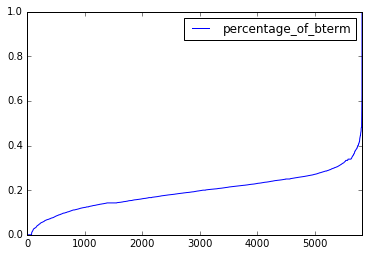

In [41]:
df['percentage_of_bterm'].sort_values().reset_index().drop('index',axis=1).plot()

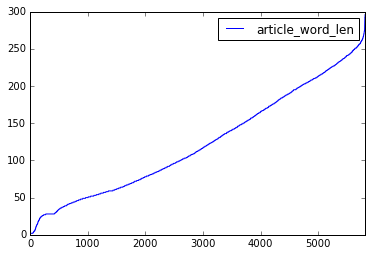

In [42]:
df['article_word_len'].sort_values().reset_index().drop('index',axis=1).plot()

## use regex remove punctuation (done)
## subset of same corpus without business terms, or wikipedia
## tf-idf
## BT and non-BT as input